<a href="https://colab.research.google.com/github/vtd9/solar_regression/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2

Deep Learning, Spring 2022

Use neural networks to the fit one year's worth of solar wind measurements.

This notebook can be accessed on Google Colab at https://drive.google.com/file/d/1OkcQGNghVPm0KJ0Zotgug7-KYTNDizFM/view?usp=sharing

In [2]:
# Import dependencies
from time import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch modules
import torch
from torch import nn

# Check GPU availability - may not be needed since relatively small models
torch.cuda.is_available()

False

# 1 Data preprocessing

The CSV file should be in the same directory as this notebook. Otherwise, update the file_name path.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

## 1.1 Read CSV and define variable categories

The CSV file is stored in a public GitHub repository for convenience. Alternatively, reference a local file or upload the file into Colab's runtime.

Ignore the mixed types warning as the last few columns are for physical constants that only span some rows.

In [3]:
url = 'https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/Sample_Data_Set.csv'
url2 ='https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/v2_Sample_Data_Set.csv'
df = pd.concat([pd.read_csv(url), pd.read_csv(url2, low_memory=False)])

In [4]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
              'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 
              'Te', 'Ti', 'Ti_para', 'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 
              'Omega_i', 'omega_pi', 'omega_pe', 'rho_i', 'rho_s', 'rho_c', 
              'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print('Independent: {}, derived: {}, dependent: {}'.format(
    len(indep_vars), len(deriv_vars), len(dep_var)))

# Convert Pandas dataframes to PyTorch tensors by column names
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

# Summary stats
df[dep_var].describe()

Independent: 18, derived: 15, dependent: 1


,k_brk
count,1.073660e+05
mean,5.348346e-06
std,3.486439e-06
min,9.965770e-07
25%,2.865257e-06
50%,4.234454e-06
75%,6.790123e-06
max,3.195988e-05


## 1.2 Prepare for feeding into network

In [113]:
# Normalize inputs & combine with dependent variable to create datasets
indep_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(indep, dim=0), dep)
deriv_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(deriv, dim=0), dep)

# Check dimensions
print(indep_set[:][0].shape, deriv_set[:][0].shape)

# Decide on training, validation, and testing splits
train_size = int(0.7 * len(df))
valid_size = int(0.15 * len(df)) + 1
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, & testing split:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = torch.utils.data.random_split(
    indep_set, splits)
train_deriv, valid_deriv, test_deriv = torch.utils.data.random_split(
    deriv_set, splits)

# Define dataloaders
BATCH_SIZE = 128
NUM_WORK = 2
train_loader_indep = torch.utils.data.DataLoader(
    dataset=train_indep, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORK)
valid_loader_indep = torch.utils.data.DataLoader(
    dataset=valid_indep, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORK)
test_loader_indep = torch.utils.data.DataLoader(
    dataset=test_indep, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
train_loader_deriv= torch.utils.data.DataLoader(
    dataset=train_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
valid_loader_deriv = torch.utils.data.DataLoader(
    dataset=valid_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
test_loader_deriv = torch.utils.data.DataLoader(
    dataset=test_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)

torch.Size([107366, 18]) torch.Size([107366, 15])
Training, validation, & testing split: [75156, 16105, 16105]


## 1.3 Visualize the input data

In [6]:
def plot_many(X, y, names, cols=6, title='', subfont=10, size=(10, 8),
              color='b', sample=10000):
  '''
  Plot multiple variables against a single one.
  '''
  num_plots = len(names)
  num_rows = int(num_plots / cols) + 1
  plt.subplots(figsize=size)
  plt.suptitle(title)

  # Random sample
  indices = torch.randperm(X.shape[0])[:sample]

  # For each variable in X
  for i in range(num_plots):
      plt.subplot(num_rows, cols, i + 1)
      plt.plot(X[:, i][indices], y[indices], ',', alpha=0.5, color=color)
      plt.title(names[i], y=1.1, fontsize=subfont)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
      plt.xticks(fontsize=0.9*subfont)
  plt.tight_layout(rect=[0, 0.01, 1, 1])
  plt.subplots_adjust(top=0.9)

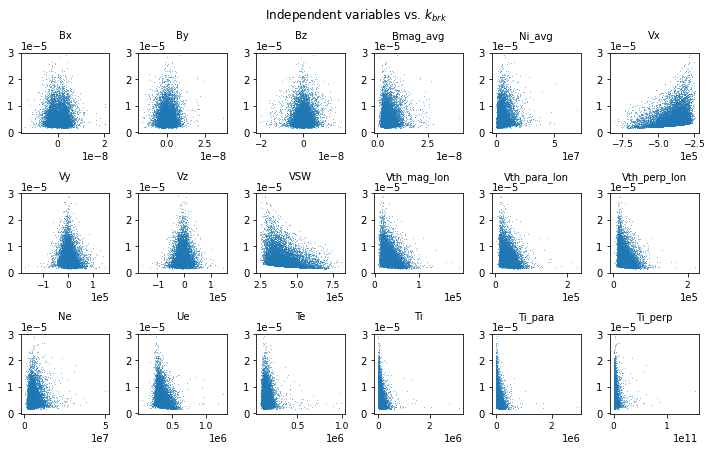

In [7]:
plot_many(indep, dep[:, 0], indep_vars, 
          title='Independent variables vs. $k_{brk}$', color='tab:blue')

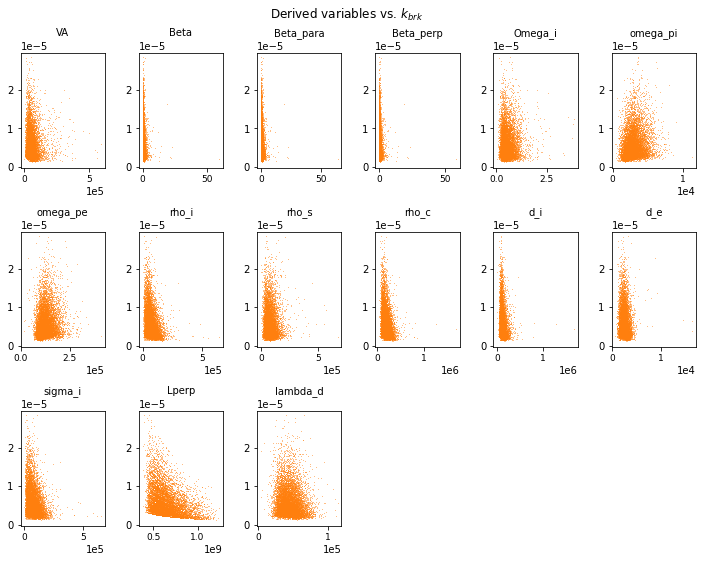

In [8]:
plot_many(deriv, dep[:, 0], deriv_vars, 
          title='Derived variables vs. $k_{brk}$', color='tab:orange')

# 2 Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

## 2.1 `Net` class

Define a general template to easily create models.

The order of activation, batch normalization, and dropout, and whether dropout is necessary when the model has batch normalization has been debated:
* https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout. 
* https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial

Here, apply activation, batch normalization, then dropout.

In [9]:
class Net(torch.nn.Module): 
  def __init__(self, n_in, hiddens, n_out, batch_norm=True, p_dropout=0.5):
    super(Net, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    layers = []
    
    # Define hidden layer(s)
    hiddens_list = [n_in, ] + list(hiddens)
    for i, hidden in enumerate(hiddens_list[:-1]):
        curr_hidden = [torch.nn.Linear(hidden, hiddens_list[i+1]),]

        # Add activation (ReLU)
        curr_hidden.append(torch.nn.ReLU())

        # If set, add batch normalization
        if batch_norm:
            curr_hidden.append(torch.nn.BatchNorm1d(hiddens_list[i+1]))

        # If set, add dropout
        if p_dropout is not None:
            curr_hidden.append(torch.nn.Dropout(p_dropout))    
            
        layers += curr_hidden 

    # Define output layer
    layers.append(torch.nn.Linear(hiddens[-1], n_out))

    # Define entire stack
    self.stack = torch.nn.Sequential(*layers)
      
  def forward(self, x):
      logits = self.stack(x)
      return logits

# Initialize parameters
def init_parameters(m):
  if isinstance(m, torch.nn.Linear):
      # weights: Kaiming initialization
      torch.nn.init.kaiming_normal_(m.weight)

      # biases: set to 0, as discussed in class
      m.bias.data.fill_(0.0) # Set bias to 0

In [10]:
def mult_models(n_in, hidden_dims, n_out, lr, momentum=0.9,
                decay=1e-5, opt_sgd=True, one_model=True):
  '''
  Create multiple models using one or more configurations for the hidden 
  layers. Return as a dictionary with keys based on the number of neurons in
  the hidden layers as well the model-specific add-ons or lack thereof.
  '''
  models_dict = {}
  for dim in hidden_dims:  
    # Batch norm & dropout of 50%
    model = Net(n_in, dim, n_out)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    if not one_model: # Create more models with less components
      # Batch norm, but no dropout
      model = Net(n_in, dim, n_out, p_dropout=None)
      model.apply(init_parameters)
      if opt_sgd:
        models_dict[str(dim) + ' no drop'] = {
            'model': model,
            'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=decay)}
      else:
            models_dict[str(dim) + ' no drop'] = {
            'model': model,
            'opt': torch.optim.Adam(model.parameters(), lr=lr)}
      
      # No norm, no dropout
      model = Net(n_in, dim, n_out, batch_norm=False, p_dropout=None)
      model.apply(init_parameters)
      if opt_sgd:
        models_dict[str(dim) + ' no norm'] = {
            'model': model,
            'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=decay)}
      else:
            models_dict[str(dim) + ' no norm'] = {
            'model': model,
            'opt': torch.optim.Adam(model.parameters(), lr=lr)}

  return models_dict

## 2.2 Training, testing, and plotting functions

Train & test functions for one loop through the datasets (aka one epoch) as well as loop over multiple epochs.

Option to configure a GPU with PyTorch.

* https://pytorch.org/docs/stable/notes/cuda.html
* https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [11]:
a = torch.tensor([])
torch.concat([a, torch.empty(3, 4)], dim=1).shape

torch.Size([3, 4])

In [140]:
def train_loop(loader, model, loss_fun, optimizer, device='cpu'):
  '''
  Train a model for one epoch - i.e., one pass through the training data set.
  Since gradients must be calculated anyways during training, store gradient
  of prediction wrt to inputs and return the average over the batches.
  '''
  train_loss = 0.0
  model = model.double()
  model = model.to(device)

  # For each batch
  for X, y in loader:
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad() # clear previous gradients
    yhat = model(X) # prediction
    loss = loss_fun(yhat, y) # compute loss
    train_loss += loss.item() # assume reduction over batch

    loss.backward() # compute gradients
    optimizer.step() # apply gradients

  # Average over number of batches
  return train_loss/len(loader)
    
def test_loop(loader, model, loss_fun, device='cpu', get_jacobian=False):
  '''
  Test a model through one pass through a validation/test data set.
  '''
  test_loss = 0.0
  model = model.double()
  model = model.to(device)

  if get_jacobian:
    jacobians = torch.tensor([])

  # No backprop during validation/testing
  with torch.no_grad():
    for i, (X, y) in enumerate(loader):
      X = X.to(device)
      y = y.to(device)
      yhat = model(X)
      test_loss += loss_fun(yhat, y).item()

      if get_jacobian:
        # Get Jacobian using torch, reducing over the batch together
        # Add in corresponding predictions for later usage
        jacobians = torch.concat(
            [jacobians, torch.concat([
                torch.autograd.functional.jacobian(model, X).sum(dim=0)[0],
                yhat, y], dim=1)])

  if get_jacobian:
    return test_loss/len(loader), jacobians
  else:
    return test_loss/len(loader)

def train_epochs(train_loader, valid_loader, model, loss_fun, optimizer, 
    epochs, verbose=False, use_gpu=False):
    '''
    Train and validate a model over multiple epochs.
    '''
    train_losses = torch.empty(epochs)
    valid_losses = torch.empty(epochs)
    grads = torch.empty(epochs, model.n_in)

    if use_gpu:
      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    else:
      device = 'cpu'

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch] = train_loop(train_loader, model, 
            loss_fun, optimizer=optimizer, device=device)
        valid_losses[epoch] = test_loop(valid_loader, model, 
                                       loss_fun, device=device)
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], valid_losses[epoch]))
    
    return train_losses, valid_losses

### 2.2.1 Multiple models

Functions to handle multiple models.

In [13]:
def train_mult_models(models, train_loader, valid_loader, loss_fun,
                      epochs=25, verbose=False, use_gpu=False,
                      train_index=0, valid_index=1):
  '''
  Train (and validate) multiple models in sequence. Assume `models` is a
  dictionary produced by the above function `mult_models`.
  '''
  fun_start = time()
  for key, value in models.items():
    start = time()
    model = value['model']
    opt = value['opt']
    models[key]['result'] = train_epochs(
        train_loader, valid_loader, model, 
        loss_fun=loss_fun, optimizer=opt, epochs=epochs, verbose=verbose,
        use_gpu=use_gpu)
    print('{0: <20}'.format(key), '{:.1f}s'.format(time() - start),
          'train loss: {:.3e}'.format(models[key]['result'][train_index][-1]),
          'valid loss: {:.3e}'.format(models[key]['result'][valid_index][-1]))
  print('Total time: {:.1f}s'.format(time() - fun_start))


def plot_mult_models(models, xlabel='Epoch', ylabel='Mean squared error',
                     yscale='log', title='', train_index=0, valid_index=1,
                     result_key='result', train_append=' training', 
                     valid_append=' validation', train_style='-', 
                     valid_style='--', figsize=(8, 5)):
  '''
  Plot the results of multiple models on the same graph, each with its own 
  training and validation performances.
  '''
  colors=itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                          'tab:purple', 'tab:pink','b', 'y', 'c', 'm', 'k',
                          'tab:gray', 'tab:olive'))
  plt.figure(figsize=figsize)
  for key, value in models.items():
    color = next(colors)
    epochs = value[result_key][0].shape[0]
    # Plot training performance
    plt.plot(np.arange(epochs), 
        value[result_key][train_index], train_style, 
        color=color, label=key+train_append)
    
    # Plot validation performance
    plt.plot(np.arange(epochs), 
        value[result_key][valid_index], valid_style, 
        color=color, label=key+valid_append)
  plt.title(title)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.1))

# 3 Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [14]:
# Standard mean squared error loss function
mse = torch.nn.MSELoss(reduction='mean') # default reduction

# Other hyperparameters
LEARN_RATE = 0.05
NUM_EPOCHS = 10

## 3.1 Three hidden layers

From prior runs, the performance of the models appear to plateau after ~3-4 epochs with a learning rate of ~0.05 to 0.1.

In [15]:
# Create container to store models, optimizers, & results in
m3 = mult_models(len(indep_vars), [(32, 16, 8), (16, 8, 4), (8, 4, 2)], 
                 n_out=1, lr=LEARN_RATE, one_model=False)
# Train
train_mult_models(m3, train_loader_indep, valid_loader_indep, mse, NUM_EPOCHS)

(32, 16, 8) drop 50% 25.3s train loss: 1.216e-11 valid loss: 1.228e-11
(32, 16, 8) no drop  23.9s train loss: 8.048e-09 valid loss: 5.542e-09
(32, 16, 8) no norm  22.2s train loss: 8.116e-09 valid loss: 8.954e-09
(16, 8, 4) drop 50%  27.4s train loss: 1.259e-11 valid loss: 1.303e-11
(16, 8, 4) no drop   24.3s train loss: 1.213e-11 valid loss: 1.270e-11
(16, 8, 4) no norm   21.5s train loss: 4.535e-09 valid loss: 3.115e-09
(8, 4, 2) drop 50%   24.9s train loss: 1.214e-11 valid loss: 1.233e-11
(8, 4, 2) no drop    23.5s train loss: 1.194e-11 valid loss: 1.215e-11
(8, 4, 2) no norm    21.5s train loss: 3.487e-09 valid loss: 3.564e-11
Total time: 214.4s


As previously observed, adding more neurons in the hidden layers does not seem to improve performance compared to a smaller model, even with a smaller regularization multiplier.

In [16]:
m3more = mult_models(len(indep_vars), [(128, 64, 32),], 
                     n_out=1, lr=LEARN_RATE, one_model=True, decay=1e-6)
key = '(128, 64, 32) drop 50%'
m3more_res = train_epochs(train_loader_indep, valid_loader_indep, 
                          m3more[key]['model'], 
                          mse, m3more[key]['opt'], epochs=10, verbose=True)

epoch: 0	training loss: 3.893e-02	validation loss: 6.514e-07
epoch: 1	training loss: 3.248e-07	validation loss: 1.337e-07
epoch: 2	training loss: 8.031e-08	validation loss: 4.744e-08
epoch: 3	training loss: 4.044e-08	validation loss: 3.540e-08
epoch: 4	training loss: 2.563e-08	validation loss: 2.010e-08
epoch: 5	training loss: 1.762e-08	validation loss: 1.506e-08
epoch: 6	training loss: 1.338e-08	validation loss: 1.412e-08
epoch: 7	training loss: 1.042e-08	validation loss: 9.642e-09
epoch: 8	training loss: 8.417e-09	validation loss: 8.064e-09
epoch: 9	training loss: 6.704e-09	validation loss: 6.429e-09


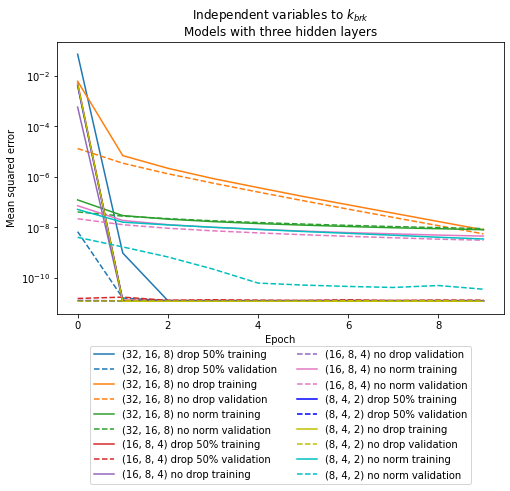

In [17]:
# Plot on log scale
plot_mult_models(m3, title='Independent variables to $k_{brk}$' 
                 + '\nModels with three hidden layers')

(1.1e-11, 1.4e-11)

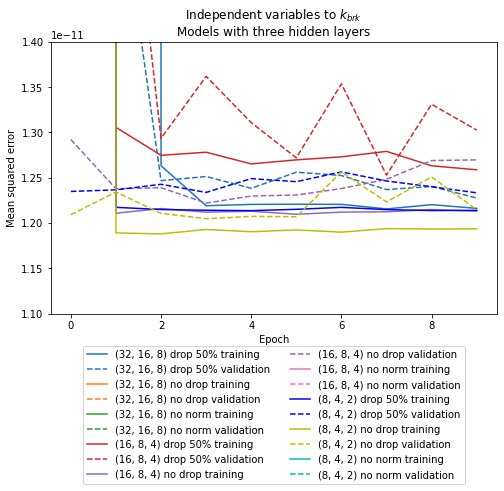

In [18]:
# Zoom in and plot on linear scale
plot_mult_models(m3, yscale='linear', title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(1.1e-11, 1.4e-11)

#### 3.1.1 ADAM

Experiment with another optimization algorithm, ADAM, instead of stochastic gradient descent (SGD).

In [19]:
m3a = mult_models(len(indep_vars), [(16, 8, 4), (8, 4, 2)], 1, 
                  lr=LEARN_RATE, opt_sgd=False, one_model=True)
train_mult_models(m3a, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(16, 8, 4) drop 50%  27.1s train loss: 4.930e-06 valid loss: 2.314e-09
(8, 4, 2) drop 50%   26.7s train loss: 1.853e-06 valid loss: 1.618e-07
Total time: 53.8s


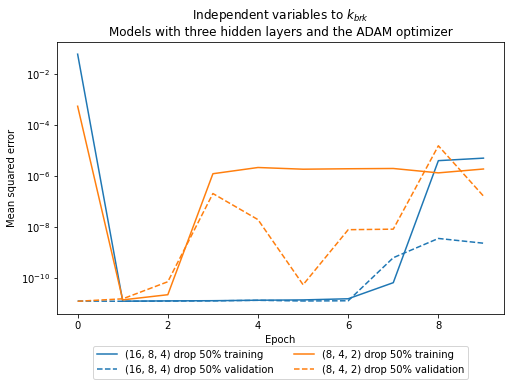

In [20]:
plot_mult_models(m3a, 
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers and the ADAM optimizer')

## 3.2 Four hidden layers

In [21]:
m4 = mult_models(len(indep_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 
                 LEARN_RATE)
train_mult_models(m4, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(24, 16, 8, 4) drop 50% 27.0s train loss: 1.230e-11 valid loss: 1.282e-11
(12, 8, 4, 2) drop 50% 27.7s train loss: 1.259e-11 valid loss: 1.264e-11
Total time: 54.7s


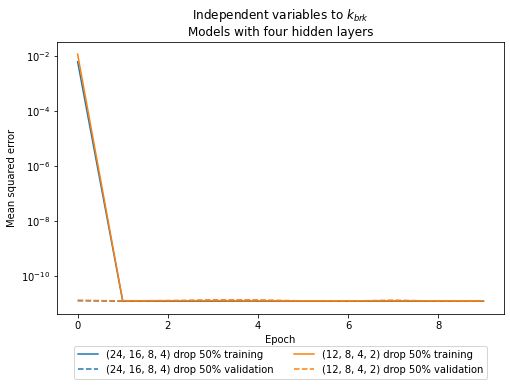

In [22]:
plot_mult_models(m4,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(1.1e-11, 1.5e-11)

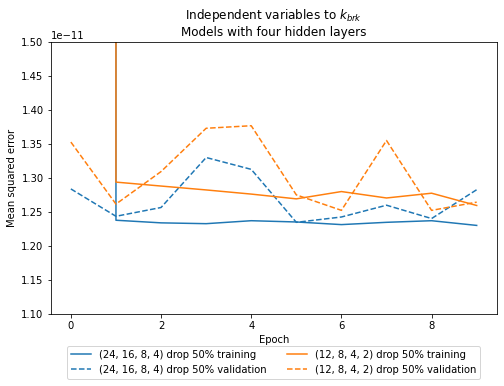

In [29]:
plot_mult_models(m4, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 3.3 Five hidden layers

In [24]:
# Create container to store models, optimizers, & results in
m5 = mult_models(len(indep_vars), [(24, 20, 16, 8, 4), (16, 12, 8, 4, 2)],
                 1, LEARN_RATE)
# Train
train_mult_models(m5, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(24, 20, 16, 8, 4) drop 50% 29.0s train loss: 1.237e-11 valid loss: 1.238e-11
(16, 12, 8, 4, 2) drop 50% 29.1s train loss: 1.220e-11 valid loss: 1.242e-11
Total time: 58.1s


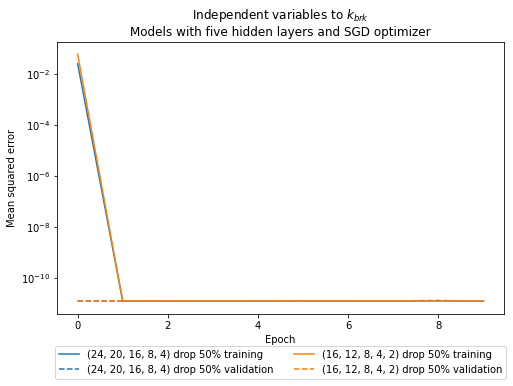

In [25]:
plot_mult_models(m5,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')

(1.1e-11, 1.4e-11)

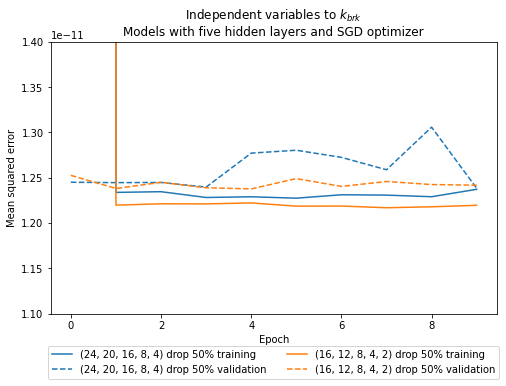

In [26]:
plot_mult_models(m5, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')
plt.ylim(1.1e-11, 1.4e-11)

## 3.4 Test dataset

Report chosen model's performance with test set & get gradients.

In [30]:
model = m5['(16, 12, 8, 4, 2) drop 50%']['model']
test_loss, j_indep = test_loop(test_loader_indep, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

Test set MSE: 1.223e-11


In [31]:
# Test set predictions
j_indep[:, -1].mean(), j_indep[:, -1].std()

(tensor(5.5975e-06, dtype=torch.float64),
 tensor(1.1466e-07, dtype=torch.float64))

# 4 Derived &rarr; dependent variables

## 4.1 Three hidden layers

In [35]:
# Create container to store models, optimizers, & results in
m3v = mult_models(len(deriv_vars), [(16, 8, 4), (8, 4, 2)], 
                  n_out=1, lr=LEARN_RATE)
# Train
train_mult_models(m3v, train_loader_deriv, valid_loader_deriv, mse, NUM_EPOCHS)

(16, 8, 4) drop 50%  27.6s train loss: 1.256e-11 valid loss: 1.265e-11
(8, 4, 2) drop 50%   25.2s train loss: 1.220e-11 valid loss: 1.215e-11
Total time: 52.8s


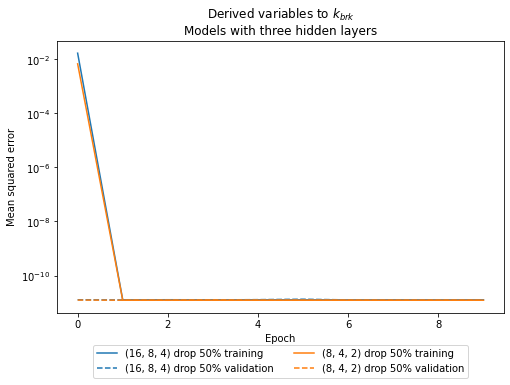

In [38]:
plot_mult_models(m3v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')

(1.1e-11, 1.5e-11)

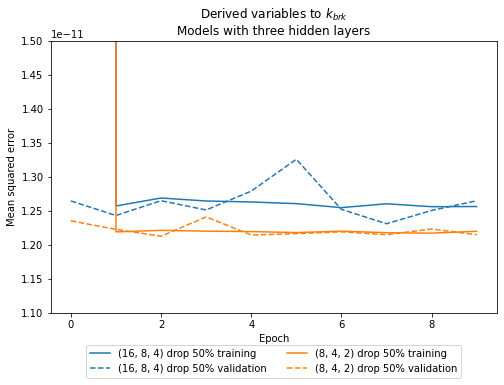

In [37]:
plot_mult_models(m3v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 4.2 Four hidden layers

In [32]:
m4v = mult_models(len(deriv_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 
                 LEARN_RATE)
train_mult_models(m4v, train_loader_deriv, valid_loader_deriv, mse, 
                  epochs=NUM_EPOCHS)

(24, 16, 8, 4) drop 50% 30.1s train loss: 1.226e-11 valid loss: 1.213e-11
(12, 8, 4, 2) drop 50% 27.3s train loss: 1.220e-11 valid loss: 1.232e-11
Total time: 57.5s


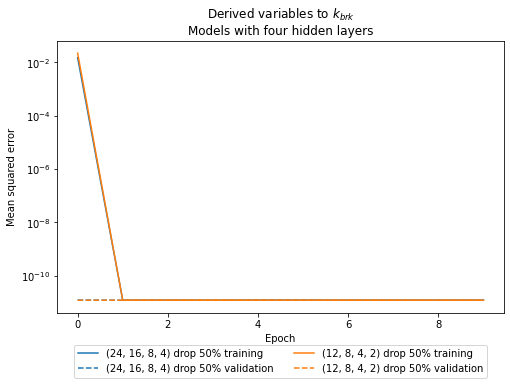

In [33]:
plot_mult_models(m4v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(1.1e-11, 1.3e-11)

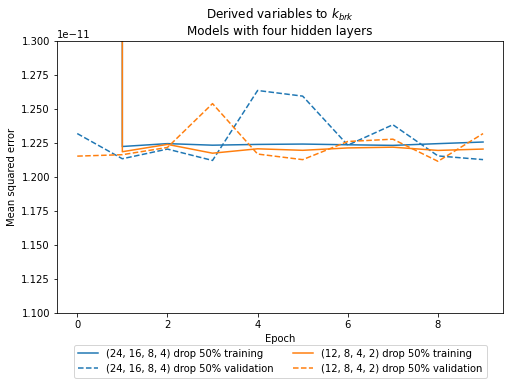

In [34]:
plot_mult_models(m4v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 4.3 Five hidden layers

In [39]:
# Create container to store models, optimizers, & results in
# Try models without dropout & batch normalization again
m5v = mult_models(len(deriv_vars), [(24, 20, 16, 8, 4), (16, 12, 8, 4, 2)],
                  1, LEARN_RATE, one_model=False)
# Train
train_mult_models(m5v, train_loader_deriv, valid_loader_deriv, mse, 
                  epochs=NUM_EPOCHS)

(24, 20, 16, 8, 4) drop 50% 30.2s train loss: 1.220e-11 valid loss: 1.216e-11
(24, 20, 16, 8, 4) no drop 28.6s train loss: 1.163e-11 valid loss: 1.192e-11
(24, 20, 16, 8, 4) no norm 24.7s train loss: 1.215e-11 valid loss: 1.219e-11
(16, 12, 8, 4, 2) drop 50% 29.9s train loss: 1.283e-11 valid loss: 1.237e-11
(16, 12, 8, 4, 2) no drop 28.8s train loss: 1.165e-11 valid loss: 1.170e-11
(16, 12, 8, 4, 2) no norm 23.7s train loss: 9.836e-10 valid loss: 7.670e-10
Total time: 165.9s


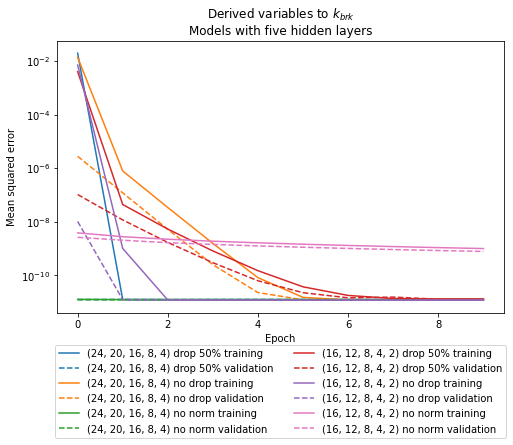

In [40]:
plot_mult_models(m5v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with five hidden layers')

(1.1e-11, 1.5e-11)

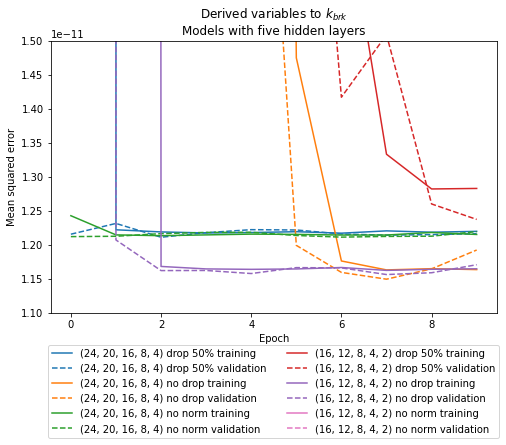

In [41]:
plot_mult_models(m5v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with five hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

In [46]:
model = m5v['(16, 12, 8, 4, 2) no drop']['model']
test_loss, j_deriv = test_loop(test_loader_deriv, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

# Test set predictions
j_deriv[:, -1].mean(), j_deriv[:, -1].std(), j_deriv.shape

Test set MSE: 1.196e-11


(tensor(4.9997e-06, dtype=torch.float64),
 tensor(7.3209e-07, dtype=torch.float64),
 torch.Size([16105, 16]))

In [47]:
1.196e-11**.5

3.4583232931581166e-06

# 5 Derivatives

## 5.1 Analytical differentiation

As described in the attached report, the derivatives of the independent and derived variables related to `k_brk` were found by hand. These are defined below for later comparison with the gradients from the neural network.

In [50]:
def dk_brk_dlambda_r(lambda_r, A=1):
  '''Derivative of k_brk wrt lambda_r'''
  return -A * lambda_r**-2

def dlamda_r_dLperp(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt Lperp'''
  return (1./9.) * C0 * Lperp**(-8./9.)*(d_e*rho_s)**(4./5.)

def dlambda_r_dd_e(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt d_e '''
  return C0 * Lperp**(1./9.) * (4./5.) * (d_e*rho_s)**(-1./5.) * rho_s

def dlambda_r_rho_s(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt rho_s'''
  return C0 * Lperp**(1./9.) * (4./5.) * (d_e*rho_s)**(-1./5.) * d_e

def dLperp_dvsw():
  '''Derivative of Lperp wrt VSW'''
  return 1./(2 * torch.pi * 10**-4)

def dde_domega_pe(omega_pe, c=2.9979E8):
  '''Derivative of '''
  return -c * omega_pe**-2

def drho_s_drho_i(Te, Ti, Z=1.0):
  '''Derivative of '''
  return (Z*Te / (2*Ti))**0.5

def drho_s_dTi(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return -0.5 * rho_i * (Z*Te / (2.0*Ti**3))**0.5

def drho_s_dTe(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return 0.5 * rho_i * (Z / (2.0*Ti*Te))**0.5

def domega_pe_dNe(Ne, e=1.6022E-19, eps0=8.8542E-12, mp=9.1094E-31):
  '''Derivative of omega_pe wrt Ne'''
  return 0.5 * (e / (eps0*mp*Ne))**0.5

def drho_i_Vth_perp_Ion(Omega_i):
  '''Derivative of rho_i wrt Vth_perp_Ion'''
  return 1/Omega_i

def drho_i_dOmega_i(Vth_perp_Ion, Omega_i):
  '''Derivative of rho_i wrt Omega_i'''
  return -Vth_perp_Ion/Omega_i**2

def dOmega_i_dB(e=1.6022E-19, mp=9.1094E-31):
  '''Derivative of Omega_i wrt B'''
  return e/mp

def dB_i_dBx(Bx, By, Bz):
  '''Derivative of B wrt Bx'''
  return Bx * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBy(Bx, By, Bz):
  '''Derivative of B wrt By'''
  return By * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBz(Bx, By, Bz):
  '''Derivative of B wrt Bz'''
  return Bz * (Bx**2 + By**2 + Bz**2)**(-0.5)

In [51]:
def derive_from_tensors(indep_vars, deriv_vars, indep_tensor, deriv_tensor):
  '''
  Derive k_brk wrt different variables using the formulas & the chain rule.
  '''
  grads = {}

  # step 1: From k_brk to lambda_r (lambda_d in spreadsheet)
  grads['lambda_d'] = dk_brk_dlambda_r(
      deriv_tensor[:, deriv_vars.index('lambda_d')])

  # step 2: lambda_r to Lperp, d_e, & rho_s
  grads['Lperp'] = grads['lambda_d'] * dlamda_r_dLperp(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['d_e'] = grads['lambda_d'] * dlambda_r_dd_e(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['rho_s'] = grads['lambda_d'] * dlambda_r_rho_s(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])

  # step 3: d_e to omega_pe; rho_s to rho_i, Ti, & Te
  grads['VSW'] = grads['Lperp'] * dLperp_dvsw()
  grads['omega_pe'] = grads['d_e'] * dde_domega_pe(
      deriv_tensor[:, deriv_vars.index('omega_pe')])
  grads['rho_i'] = grads['rho_s'] * drho_s_drho_i(
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Ti'] = grads['rho_s'] * drho_s_dTi(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Te'] = grads['rho_s'] * drho_s_dTe(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])

  # step 4: omega_pe to Ne; rho_i to Vth_perp_Ion & Omega_i
  grads['Ne'] = grads['omega_pe'] * domega_pe_dNe(
      indep_tensor[:, indep_vars.index('Ne')])
  grads['Vth_perp_Ion'] = grads['rho_i'] * drho_i_Vth_perp_Ion(
      deriv_tensor[:, deriv_vars.index('Omega_i')])
  grads['Omega_i'] = grads['rho_i'] * drho_i_dOmega_i(
      indep_tensor[:, indep_vars.index('Vth_perp_Ion')], 
      deriv_tensor[:, deriv_vars.index('Omega_i')])

  # step 5: B and its components
  grads['Bmag_avg'] = grads['Omega_i'] * dOmega_i_dB()
  grads['Bx'] = grads['Bmag_avg'] * dB_i_dBx(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['By'] = grads['Bmag_avg'] * dB_i_dBy(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['Bz'] = grads['Bmag_avg'] * dB_i_dBz(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])   
  return grads

In [52]:
# Execute
grads = derive_from_tensors(indep_vars, deriv_vars,
                            indep_set[:][0], deriv_set[:][0])
grads_unnorm = derive_from_tensors(indep_vars, deriv_vars,
                            indep, deriv)

print('Derivative of k_brk wrt to...\nNormalized inputs')
for key, value in grads.items():
  print('{0: <15}'.format(key), 
        '{:.3e}\t{:.3e}'.format(value.max().item(), value.min().item()))
print('*'*60, '\nUnnormalized inputs')
for key, value in grads_unnorm.items():
  print('{0: <15}'.format(key), 
        '{:.3e}\t{:.3e}'.format(value.max().item(), value.min().item()))

Derivative of k_brk wrt to...
Normalized inputs
lambda_d        -1.389e+03	-4.555e+07
Lperp           -7.380e+01	-3.858e+02
d_e             -1.650e+02	-6.370e+03
rho_s           -3.421e+01	-1.571e+06
VSW             -1.175e+05	-6.140e+05
omega_pe        3.566e+17	1.608e+16
rho_i           -1.278e+02	-7.204e+05
Ti              4.229e+05	1.545e+01
Te              -1.036e+02	-1.874e+03
Ne              2.796e+30	6.171e+27
Vth_perp_Ion    -5.953e+04	-1.166e+08
Omega_i         7.635e+06	9.869e+04
Bmag_avg        1.343e+18	1.736e+16
Bx              1.157e+18	-1.125e+18
By              8.315e+17	-8.069e+17
Bz              1.042e+18	-9.215e+17
************************************************************ 
Unnormalized inputs
lambda_d        -6.056e-12	-1.986e-07
Lperp           -1.385e-12	-7.238e-12
d_e             -7.813e-07	-3.016e-05
rho_s           -4.864e-09	-2.234e-04
VSW             -2.204e-09	-1.152e-08
omega_pe        9.332e-07	4.207e-08
rho_i           -2.020e-08	-1.139e-04
Ti         

In [90]:
def one_subplot(rows, cols, i, key, subtitle=10):
      plt.subplot(rows, cols, i + 1)
      plt.title(key, y=1.15, fontsize=subtitle)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
      plt.xticks(fontsize=0.8*subtitle, rotation=45)
      plt.yticks(fontsize=0.8*subtitle)

def plot_grads(grads, dep, title='', cols=6, sample=5000, figsize=(7, 7), 
               names=None, color='k'):
  '''
  Plot partial derivatives from generated dictionary or those from a
  neural network.
  '''
  plt.subplots(figsize=figsize)
  plt.suptitle(title)

  if type(grads) == dict:
    rows = int(len(grads) / cols) + 1
    # Take random sample
    indices = torch.randperm(list(grads.values())[0].shape[0])[:sample]
    for i, (key, value) in enumerate(grads.items()):
      one_subplot(rows, cols, i, key)
      plt.plot(value[indices], dep[indices], ',', color=color)

  else:
    rows = int(grads.shape[-1] / cols) + 1
    # Assume data has already been shuffled before being fed into NN
    assert len(names) == grads.shape[-1]
    for i, key in enumerate(names):
      one_subplot(rows, cols, i, key)
      value = grads[:, i]
      plt.plot(value[:sample], dep[:sample], ',', color=color)
  plt.tight_layout(rect=[0, 0.01, 1, 1])
  plt.subplots_adjust(top=0.88)

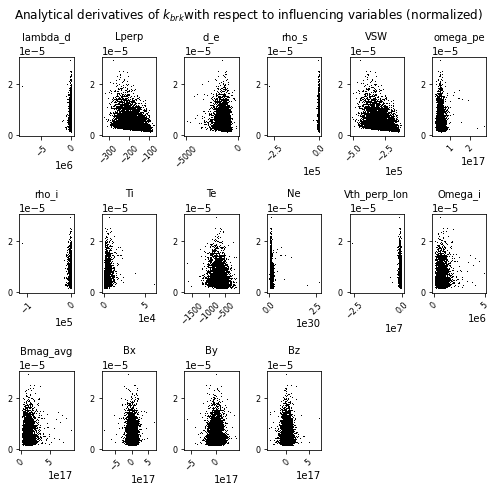

In [91]:
plot_grads(grads, dep, 
           title='Analytical derivatives of $k_{brk}$' +
           'with respect to influencing variables (normalized)')

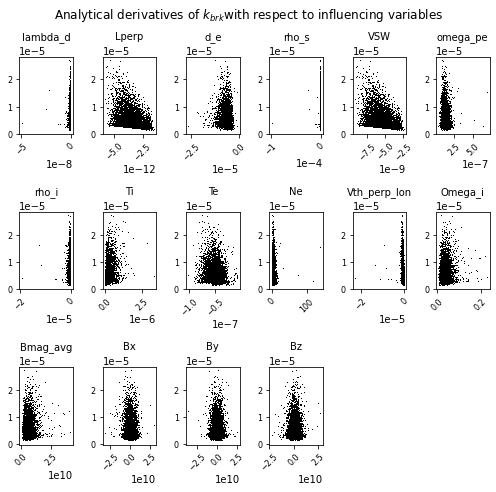

In [92]:
plot_grads(grads_unnorm, dep, 
           title='Analytical derivatives of $k_{brk}$' +
           'with respect to influencing variables')

## 5.2 Neural network gradients

From the chosen models, get the Jacobian tensor.

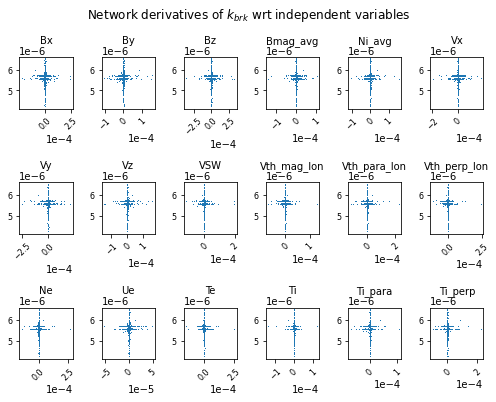

In [95]:
plot_grads(j_indep[:, 0:len(indep_vars)], j_indep[:, -1], names=indep_vars,
           title='Network derivatives of $k_{brk}$ wrt independent variables',
           color='tab:blue')

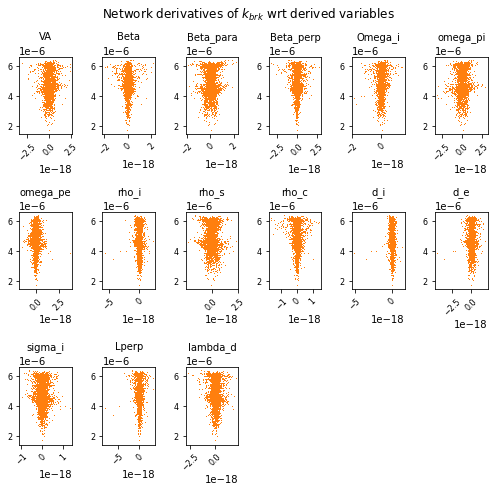

In [94]:
plot_grads(j_deriv[:, 0:len(deriv_vars)], j_deriv[:, -1], names=deriv_vars,
           title='Network derivatives of $k_{brk}$ wrt derived variables',
           color='tab:orange')

# Appendix

Simple experiments with key functionality.

* https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
* https://pytorch.org/docs/stable/generated/torch.autograd.grad.html

## Experiment: just $\lambda_{r}$ or $L_{perp}$ vs. $k_{brk}$

In [116]:
# lambda_r is the last (15-1=14) column in the derived variables
lam_r_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(deriv[:, 14].reshape(-1, 1), dim=0), dep)

# Check dimensions
print(lam_r_set[:][0].shape)

# Split
train_lam_r, valid_lam_r, test_lam_r = torch.utils.data.random_split(
    lam_r_set, splits)

# Define dataloaders
BATCH_SIZE = 128
NUM_WORK = 2
train_loader_lam_r = torch.utils.data.DataLoader(
    dataset=train_lam_r, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
valid_loader_lam_r = torch.utils.data.DataLoader(
    dataset=valid_lam_r, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
test_loader_lam_r = torch.utils.data.DataLoader(
    dataset=test_lam_r, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)

torch.Size([107366, 1])


In [125]:
m3_lam_r = mult_models(1, [(16, 8, 4), (8, 4, 2)], n_out=1, lr=LEARN_RATE)
train_mult_models(m3_lam_r, train_loader_lam_r, valid_loader_lam_r, 
                  mse, NUM_EPOCHS)

(16, 8, 4) drop 50%  28.8s train loss: 1.252e-11 valid loss: 1.279e-11
(8, 4, 2) drop 50%   25.1s train loss: 1.222e-11 valid loss: 1.220e-11
Total time: 53.9s


In [141]:
model = m3_lam_r['(8, 4, 2) drop 50%']['model']
test_loss, j_lam_r = test_loop(test_loader_lam_r, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

Test set MSE: 1.222e-11


Text(0, 0.5, 'yhat')

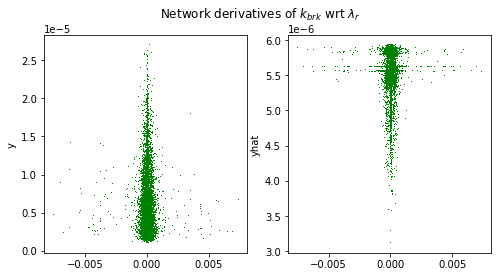

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Network derivatives of $k_{brk}$ wrt $\lambda_r$')

# y: actual labels
ax1.plot(j_lam_r[:, 0].reshape(-1, 1), j_lam_r[:, -1], 'g,')
ax1.set_ylabel('y')

# yhat: predictions
ax2.plot(j_lam_r[:, 0].reshape(-1, 1), j_lam_r[:, -2], 'g,')
ax2.set_ylabel('yhat')

In [136]:
# Lperp is the second to last column in the derived variables
Lperp_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(deriv[:, 13].reshape(-1, 1), dim=0), dep)

# Check dimensions
print(Lperp_set[:][0].shape)

# Split
train_Lperp, valid_Lperp, test_Lperp = torch.utils.data.random_split(
    Lperp_set, splits)

# Define dataloaders
BATCH_SIZE = 128
NUM_WORK = 2
train_loader_Lperp = torch.utils.data.DataLoader(
    dataset=train_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
valid_loader_Lperp = torch.utils.data.DataLoader(
    dataset=valid_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
test_loader_Lperp = torch.utils.data.DataLoader(
    dataset=test_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)

torch.Size([107366, 1])


In [137]:
m3_Lperp = mult_models(1, [(16, 8, 4), (8, 4, 2)], n_out=1, lr=LEARN_RATE)
train_mult_models(m3_Lperp, train_loader_Lperp, valid_loader_Lperp, 
                  mse, NUM_EPOCHS)

(16, 8, 4) drop 50%  35.6s train loss: 1.399e-11 valid loss: 1.328e-11
(8, 4, 2) drop 50%   26.0s train loss: 1.215e-11 valid loss: 1.180e-11
Total time: 61.6s


In [163]:
model = m3_Lperp['(8, 4, 2) drop 50%']['model']
test_loss, j_Lperp = test_loop(test_loader_Lperp, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

Test set MSE: 1.286e-11


Text(0, 0.5, 'yhat')

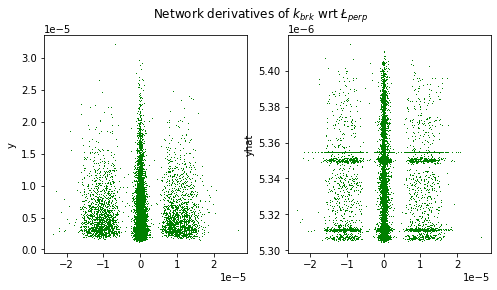

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Network derivatives of $k_{brk}$ wrt $\L_{perp}$')

# y: actual labels
ax1.plot(j_Lperp[:, 0].reshape(-1, 1), j_Lperp[:, -1], 'g,')
ax1.set_ylabel('y')

# yhat: predictions
ax2.plot(j_Lperp[:, 0].reshape(-1, 1), j_Lperp[:, -2], 'g,')
ax2.set_ylabel('yhat')

No breakthrough: no obvious similarity to the analytical derivatives is observed.

In [ ]:
i0 = torch.tensor([2., 4.], requires_grad=True)
i1 = torch.tensor([3., 5.], requires_grad=True)
z = 2.0*i0 + 3.0*i1 # dz_di0 = 2, dz_di1 = 3
y = z**2 # dy_dz = 2z

print('z:', z.detach(), '\ty:', y.detach())
print('dy/dz:', torch.autograd.grad(y, z, torch.ones(z.shape)))
print('dz/di0:', torch.autograd.grad(z, i0, torch.ones(i0.shape)))
print('dz/di1:', torch.autograd.grad(z, i1, torch.ones(i1.shape)))

z: tensor([13., 23.]) 	y: tensor([169., 529.])
dy/dz: (tensor([26., 46.]),)
dz/di0: (tensor([2., 2.]),)
dz/di1: (tensor([3., 3.]),)


Test Jacobian method with a simple neural network. Synthetic data functions are based on Dive into Deep Learning's examples:

* https://d2l.ai/chapter_linear-networks/linear-regression-concise.html
* https://d2l.ai/_modules/d2l/mxnet.html#synthetic_data

PyTorch documentation on `torch.autograd.functional.jacobian`: https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html

epoch 0, loss 0.781366,             grad compare 0.871210
epoch 1, loss 0.129156,             grad compare 0.316755
epoch 2, loss 0.081485,             grad compare 0.227037
epoch 3, loss 0.060012,             grad compare 0.195296
epoch 4, loss 0.044727,             grad compare 0.162777
************************************************************
Print one batch input & its Jacobian
Jacobian shape: torch.Size([10, 1, 10, 2])
2X: tensor([[-1.5335, -1.6009],
        [-0.7741,  0.0812],
        [-0.3047,  3.0248],
        [-0.5671,  1.8633],
        [-1.1914, -1.4560],
        [-2.6476, -0.4524],
        [ 1.6484, -0.7830],
        [ 1.4517, -1.6066],
        [-1.5659, -0.9068],
        [-1.1911,  2.4065]])
Jacobian summed: tensor([[-1.0973e+00,  1.2575e-03],
        [-1.1010e+00, -5.8967e-02],
        [-1.0731e+00,  1.1218e-01],
        [-8.8979e-01,  1.2311e-02],
        [-1.0973e+00,  1.2575e-03],
        [-3.3781e+00,  3.0778e-04],
        [ 1.9680e+00,  4.7839e-02],
        [ 1.761

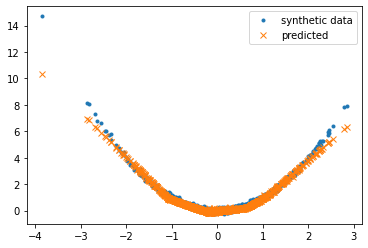

In [ ]:
def load_array(data_arrays, batch_size, is_train=True): 
  '''Construct a PyTorch data iterator.'''
  dataset = torch.utils.data.TensorDataset(*data_arrays)
  return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def synthetic(w, b, num_examples, stdev=0.1):
  '''Generate y = Xw + b + noise.'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, stdev, y.shape)

  print('X.shape:', X.shape)
  return X, torch.reshape(y, (-1, 1))

def synthetic_only1(w, b, num_examples, stdev=0.1):
  '''y only depends on 1st input'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X[:, 0].reshape(-1, 1), w[0].unsqueeze(0)) + b
  y += torch.normal(0, stdev, y.shape)

  print('X.shape:', X.shape)
  return X, torch.reshape(y, (-1, 1))

def synthetic_quad(w, b, num_examples, stdev=0.1):
  '''Generate y = X0**2 + noise. Other input has no effect...'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = X[:, 0]**2
  y += torch.normal(0, stdev, y.shape)
  return X, torch.reshape(y, (-1, 1)) 

def train(data_iter, net, loss_fun, opt, gen_fun, num_epochs=3, 
    true_w=torch.tensor([2, -3.4])):
    '''Train a model'''
    # Store values at each epoch
    losses = np.empty(num_epochs)
    grad_losses = np.empty(num_epochs)

    # Train
    for epoch in range(num_epochs):
        loss_sum = 0.0
        grad_loss = 0.0
        for X, y in data_iter:
            # Forward
            yhat = net(X)
            loss = loss_fun(yhat, y)
            loss_sum += loss.item()

            # Backprop
            opt.zero_grad()
            loss.backward(retain_graph=True)
            grad_loss += get_jacobian(X, net, gen_fun, true_w=true_w)
            opt.step()

        losses[epoch] = loss_sum/len(data_iter)    
        grad_losses[epoch] = grad_loss/len(data_iter)
        print(f'epoch {epoch}, loss {losses[epoch]:f}, \
            grad compare {grad_losses[epoch]:f}')
    return X, y

def test_linear(w, b, gen_fun, net, batch_size=10, lr=0.005, momentum=0.9):
    # Generate data
    features, labels = gen_fun(w, b, 1000)

    # Define optimizer
    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # Train
    return train(load_array((features, labels), batch_size=batch_size), 
        net, torch.nn.MSELoss(), opt, gen_fun, num_epochs=5)

def plot_fit(gen_fun, w, b, model, num_examples=1000, idx=0):
    x, y = gen_fun(w, b, num_examples)
    x = x.detach()
    y = y.detach()
    yhat = model(x).detach()
    plt.plot(x[:, idx], y, '.', label='synthetic data')
    plt.plot(x[:, idx], yhat, 'x', label='predicted')
    plt.legend()
    plt.show()

def run_net(net, gen_fun=synthetic, plot=True, hand_calc=False):
    # Parameters in underlying formula
    true_w = torch.tensor([2, -3.4])
    true_b = 4.2

    X, y = test_linear(true_w, true_b, gen_fun, net)
    X = X.detach()
    y = y.detach()

    if hand_calc:
        w1 = net[0].weight.detach()
        w2 = net[2].weight.detach()
        z1 = X @ w1.T + net[0].bias.detach()
        a1 = torch.nn.ReLU()(z1)
        yhat = a1 @ w2.T + net[2].bias.detach()

    # Get last jacobian
    print('*'*60)
    get_jacobian(X, net, gen_fun, true_w, true_b, True, True)

def get_jacobian(X, net, gen_fun=synthetic_only1, true_w=None, true_b=False, 
    verbose=False, plot=False):
    with torch.no_grad():
        # Muck around with jacobian
        jacobian = torch.autograd.functional.jacobian(net, X)
        j_sum = jacobian.sum(dim=0)[0]

        # True gradients
        if gen_fun == synthetic_only1:
          # Derivative wrt 2nd input is 0
          # Sometimes can get pretty low mse differences, like 0.00113
            true_deriv = torch.concat(
                [true_w.repeat(j_sum.shape[0], 1)[:, 0].reshape(-1, 1),
                 torch.zeros((j_sum.shape[0], 1)).reshape(-1, 1)], 
                 axis=1)
        elif gen_fun == synthetic_quad:
          # Derivative wrt 2nd input is also 0
            true_deriv =  torch.concat(
                [2*X[:, 0].reshape(-1, 1), 
                 torch.zeros((j_sum.shape[0], 1)).reshape(-1, 1)], 
                 axis=1)
        else:
            true_deriv = true_w

        # Compute performance
        diff = true_deriv - j_sum
        mse_grad = torch.nn.MSELoss()(true_deriv, j_sum).item()
        if verbose: 
            print('Print one batch input & its Jacobian')
            print('Jacobian shape:', jacobian.shape)
            print('2X:', 2*X)
            print('Jacobian summed:', j_sum)
            print('raw difference:', diff, 
                  '\nmse difference: {:.3f}'.format(mse_grad))
        
        # Generate data & plot it with trained net
        if plot:
            plot_fit(gen_fun, true_w, true_b, net)
    return mse_grad

# Neural network that takes 2 features and outputs 1 value per sample
net = torch.nn.Sequential(nn.Linear(2, 10), torch.nn.ReLU(), nn.Linear(10, 1))
run_net(net, synthetic_quad) # change synthesis arg to test another function